In [ ]:
import sys
import os


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix

from sklearn.metrics import pairwise_distances
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from sklearn.decomposition import PCA

import scanpy as sc
import anndata as ad
from dotmap import DotMap

import torch
from transformers import AutoTokenizer, TrainingArguments, MambaForCausalLM

current_dir = os.getcwd()
sys.path.append(os.path.abspath(os.path.join(current_dir, "../..")))

from genemamba.models import Classifier, GeneMamba, GeneMambaForCellAnnotation, GeneMambaForGeneClassification, GeneMamba2
from genemamba.utils import build_dataset, MambaTrainer, prepare_data, pearson_correlation, load_g2v, kl_divergence, jensen_shannon_divergence

In [ ]:
from transformers import PretrainedConfig

config = PretrainedConfig.from_dict({
    "d_model": 512,
    "mamba_layer": 24,
})

# please replace the paths to the downloaded checkpoint and tokenizer files
model = GeneMamba(config, model_path="/path/to/ckpts/downstream/GeneMamba/checkpoint", tokenizer_path="/path/to/gene_tokenizer.json", args=None)

The embeddings of Gene2Vec are generated by using Gen2Vec model, each gene corresponds to one embedding;

The embeddings of scGPT are obtained by using the provided function of scGPT, each gene corresponds to one embedding;

Because of the scFoundation model doesn't provide the method to get gene embeddings directly, we do a mean pooling of the generated context-awared embeddings of scFoundation on downstream datasets.

In [5]:
g2v = load_g2v("resources/gene2vec_embeddings.txt")

In [6]:
scgpt = pd.read_csv("resources/scGPT_genenames.csv")
scgpt_embeddings = np.load('resources/scGPT_gene.npy')
wv_scgpt, vocabulary_scgpt = scgpt_embeddings, scgpt["gene_name"].to_numpy()

input_gene_to_idx = {gene: idx for idx, gene in enumerate(vocabulary_scgpt)}

In [7]:
scFoundation_names = np.load("resources/scFoundation_gene_names.npy", allow_pickle=True)
scFoundation_gene_embeddings = np.load("resources/scFoundation_gene.npy")
scFoundation_names_list = [item for item in scFoundation_names]

In [8]:
s_mamba = set(model.symbol2id.keys())
s_g2v = set(g2v.keys())
s_scgpt = set(input_gene_to_idx.keys())
s_scfoundation = set(scFoundation_names_list)

gene_common = s_mamba.intersection(s_g2v).intersection(s_scgpt).intersection(s_scfoundation)
print(f"Number of common genes: {len(gene_common)}")

Number of common genes: 15893


In [9]:
def get_results(model_name, model, g2v, pairs_df, mode):

    correlations = {"pearson_correlation": [], "cosine_similarity": []}

    for i in range(pairs_df.shape[0]):
        gene1 = pairs_df.iloc[i]["Gene1"]
        gene2 = pairs_df.iloc[i]["Gene2"]

        if gene1 in gene_common and gene2 in gene_common:

            if model_name == "GeneMamba":
                try:
                    gene1_tensor = torch.tensor(model.tokenizer.encode(model.symbol2id[gene1]), dtype = torch.int64).to(model.device)
                    gene2_tensor = torch.tensor(model.tokenizer.encode(model.symbol2id[gene2]), dtype = torch.int64).to(model.device)
                except KeyError:
                    # print(f"UNK gene: {gene1} or {gene2}")
                    continue

                gene1_embedding = model.get_gene_embedding(gene1_tensor)
                gene2_embedding = model.get_gene_embedding(gene2_tensor)
            elif model_name == "g2v":
                try:
                    gene1_embedding = torch.tensor(g2v[gene1]).unsqueeze(0).to("cpu")
                    gene2_embedding = torch.tensor(g2v[gene2]).unsqueeze(0).to("cpu")
                except KeyError:
                    # print(f"G2V UNK gene: {gene1} or {gene2}")
                    continue
            elif model_name == "scgpt":
                try:
                    gene1_embedding = torch.tensor(wv_scgpt[input_gene_to_idx[gene1]]).unsqueeze(0).to(model.device)
                    gene2_embedding = torch.tensor(wv_scgpt[input_gene_to_idx[gene2]]).unsqueeze(0).to(model.device)
                except KeyError:
                    # print(f"G2V UNK gene: {gene1} or {gene2}")
                    continue
            elif model_name == "scFoundation":
                try:
                    gene1_embedding = torch.tensor(scFoundation_gene_embeddings[scFoundation_names_list.index(gene1)]).unsqueeze(0).to(model.device)
                    gene2_embedding = torch.tensor(scFoundation_gene_embeddings[scFoundation_names_list.index(gene2)]).unsqueeze(0).to(model.device)
                except KeyError:
                    # print(f"scFoundation UNK gene: {gene1} or {gene2}")
                    continue
        else:
            # print(f"UNK gene: {gene1} or {gene2}")
            continue
        
        if mode == "positive":
            pearson_correlation_value = pearson_correlation(gene1_embedding, gene2_embedding)
            cosine_similarity_value = torch.nn.functional.cosine_similarity(gene1_embedding, gene2_embedding)
        elif mode == "negative":
            pearson_correlation_value = pearson_correlation(gene1_embedding, gene2_embedding)
            cosine_similarity_value = torch.nn.functional.cosine_similarity(gene1_embedding, gene2_embedding)

        correlations["pearson_correlation"].append(pearson_correlation_value.item())
        correlations["cosine_similarity"].append(cosine_similarity_value.item())
    
    return correlations

In [10]:
all_pairs_df = pd.read_csv("resources/combined_gene2vec.csv")
positive_df = all_pairs_df[all_pairs_df["Label"] == 1]
negative_df = all_pairs_df[all_pairs_df["Label"] == 0]
positive_df.shape, negative_df.shape

((144148, 3), (145884, 3))

In [11]:
correlations_g2v_positive = get_results("g2v", model, g2v, positive_df, "positive")
correlations_scgpt_positive = get_results("scgpt", model, g2v, positive_df, "positive")
correlations_scfoundation_positive = get_results("scFoundation", model, g2v, positive_df, "positive")
correlations_mamba_positive = get_results("GeneMamba", model, g2v, positive_df, "positive")

correlations_g2v_negative = get_results("g2v", model, g2v, negative_df, "negative")
correlations_scgpt_negative = get_results("scgpt", model, g2v, negative_df, "negative")
correlations_scfoundation_negative = get_results("scFoundation", model, g2v, negative_df, "negative")
correlations_mamba_negative = get_results("GeneMamba", model, g2v, negative_df, "negative")

In [26]:
correlations_mamba = {"pearson_correlation": correlations_mamba_positive["pearson_correlation"] + correlations_mamba_negative["pearson_correlation"], "cosine_similarity": correlations_mamba_positive["cosine_similarity"] + correlations_mamba_negative["cosine_similarity"]}
correlations_g2v = {"pearson_correlation": correlations_g2v_positive["pearson_correlation"] + correlations_g2v_negative["pearson_correlation"], "cosine_similarity": correlations_g2v_positive["cosine_similarity"] + correlations_g2v_negative["cosine_similarity"]}
correlations_scgpt = {"pearson_correlation": correlations_scgpt_positive["pearson_correlation"] + correlations_scgpt_negative["pearson_correlation"], "cosine_similarity": correlations_scgpt_positive["cosine_similarity"] + correlations_scgpt_negative["cosine_similarity"]}
correlations_scfoundation = {"pearson_correlation": correlations_scfoundation_positive["pearson_correlation"] + correlations_scfoundation_negative["pearson_correlation"], "cosine_similarity": correlations_scfoundation_positive["cosine_similarity"] + correlations_scfoundation_negative["cosine_similarity"]}

Gene-Gene Pairs Experiment:


Draw the box plot figure, compare with other foundation models;

Draw the gene pairs smilarity distribution figure to check the alignment of positive and negative pairs.

In [13]:
len(correlations_mamba["pearson_correlation"]), len(correlations_mamba["cosine_similarity"])

(230325, 230325)

In [14]:
def diff_ratio(correlations_positive, correlations_negative):
    mean_positive_pearson_correlation = np.mean(np.abs(correlations_positive["pearson_correlation"]))
    mean_positive_cosine_similarity = np.mean(np.abs(correlations_positive["cosine_similarity"]))
    
    mean_negative_pearson_correlation = np.mean(np.abs(correlations_negative["pearson_correlation"]))
    mean_negative_cosine_similarity = np.mean(np.abs(correlations_negative["cosine_similarity"]))

    diff_pearson_correlation = mean_positive_pearson_correlation - mean_negative_pearson_correlation
    diff_cosine_similarity = mean_positive_cosine_similarity - mean_negative_cosine_similarity

    diff_ratio_pearson_correlation = diff_pearson_correlation / mean_negative_pearson_correlation
    diff_ratio_cosine_similarity = diff_cosine_similarity / mean_negative_cosine_similarity

    return diff_ratio_pearson_correlation, diff_ratio_cosine_similarity

In [15]:
diff_ratio_pearson_correlation_mamba, diff_ratio_cosine_similarity_mamba = diff_ratio(correlations_mamba_positive, correlations_mamba_negative)

diff_ratio_pearson_correlation_g2v, diff_ratio_cosine_similarity_g2v = diff_ratio(correlations_g2v_positive, correlations_g2v_negative)

diff_ratio_pearson_correlation_scgpt, diff_ratio_cosine_similarity_scgpt = diff_ratio(correlations_scgpt_positive, correlations_scgpt_negative)

diff_ratio_pearson_correlation_scfoundation, diff_ratio_cosine_similarity_scfoundation = diff_ratio(correlations_scfoundation_positive, correlations_scfoundation_negative)

print(f"diff_ratio_pearson_correlation_mamba: {diff_ratio_pearson_correlation_mamba}, diff_ratio_cosine_similarity_mamba: {diff_ratio_cosine_similarity_mamba}")
print(f"diff_ratio_pearson_correlation_g2v: {diff_ratio_pearson_correlation_g2v}, diff_ratio_cosine_similarity_g2v: {diff_ratio_cosine_similarity_g2v}")
print(f"diff_ratio_pearson_correlation_scgpt: {diff_ratio_pearson_correlation_scgpt}, diff_ratio_cosine_similarity_scgpt: {diff_ratio_cosine_similarity_scgpt}")
print(f"diff_ratio_pearson_correlation_scfoundation: {diff_ratio_pearson_correlation_scfoundation}, diff_ratio_cosine_similarity_scfoundation: {diff_ratio_cosine_similarity_scfoundation}")

diff_ratio_pearson_correlation_mamba: 0.19870390880053612, diff_ratio_cosine_similarity_mamba: 0.19865301899458662
diff_ratio_pearson_correlation_g2v: 0.18875753057066788, diff_ratio_cosine_similarity_g2v: 0.18869997345169673
diff_ratio_pearson_correlation_scgpt: 0.10188136701687517, diff_ratio_cosine_similarity_scgpt: 0.10187574132268337
diff_ratio_pearson_correlation_scfoundation: -0.005005172280762562, diff_ratio_cosine_similarity_scfoundation: -0.0050055027354772175


In [16]:
diff_df = pd.DataFrame({"model": ["GeneMamba", "g2v", "scgpt", "scFoundation"], "diff_ratio_pearson_correlation": [diff_ratio_pearson_correlation_mamba, diff_ratio_pearson_correlation_g2v, diff_ratio_pearson_correlation_scgpt, diff_ratio_pearson_correlation_scfoundation], "diff_ratio_cosine_similarity": [diff_ratio_cosine_similarity_mamba, diff_ratio_cosine_similarity_g2v, diff_ratio_cosine_similarity_scgpt, diff_ratio_cosine_similarity_scfoundation]})

diff_df

,model,diff_ratio_pearson_correlation,diff_ratio_cosine_similarity
0,GeneMamba,0.198704,0.198653
1,g2v,0.188758,0.188700
2,scgpt,0.101881,0.101876
3,scFoundation,-0.005005,-0.005006


In [17]:
def normalize_data(positive_hist, negative_hist):
    positive_hist = np.array(positive_hist)
    negative_hist = np.array(negative_hist)
    
    positive_prob = positive_hist / np.sum(positive_hist)
    negative_prob = negative_hist / np.sum(negative_hist)

    return positive_prob, negative_prob

In [18]:
import seaborn as sns

In [19]:
def calculate_divergence(positive, negative):
    # calculate the mean and standard deviation for both datasets
    mean_positive = np.mean(positive)
    std_positive = np.std(positive)

    mean_negative = np.mean(negative)
    std_negative = np.std(negative)

    # calculate the 2 sigma range
    x_min = min(mean_positive - 2 * std_positive, mean_negative - 2 * std_negative)
    x_max = max(mean_positive + 2 * std_positive, mean_negative + 2 * std_negative)

    bins = np.linspace(x_min, x_max, 100)
    positive_hist, bin_edges = np.histogram(positive, bins=bins, density=False)
    negative_hist, _ = np.histogram(negative, bins=bins, density=False)

    # make probability distributions
    positive_prob = positive_hist / np.sum(positive_hist)
    negative_prob = negative_hist / np.sum(negative_hist)

    # calculate the KL divergence and JS divergence
    kl_divergence_value = kl_divergence(positive_prob, negative_prob)
    js_divergence_value = jensen_shannon_divergence(positive_prob, negative_prob)
    return kl_divergence_value, js_divergence_value


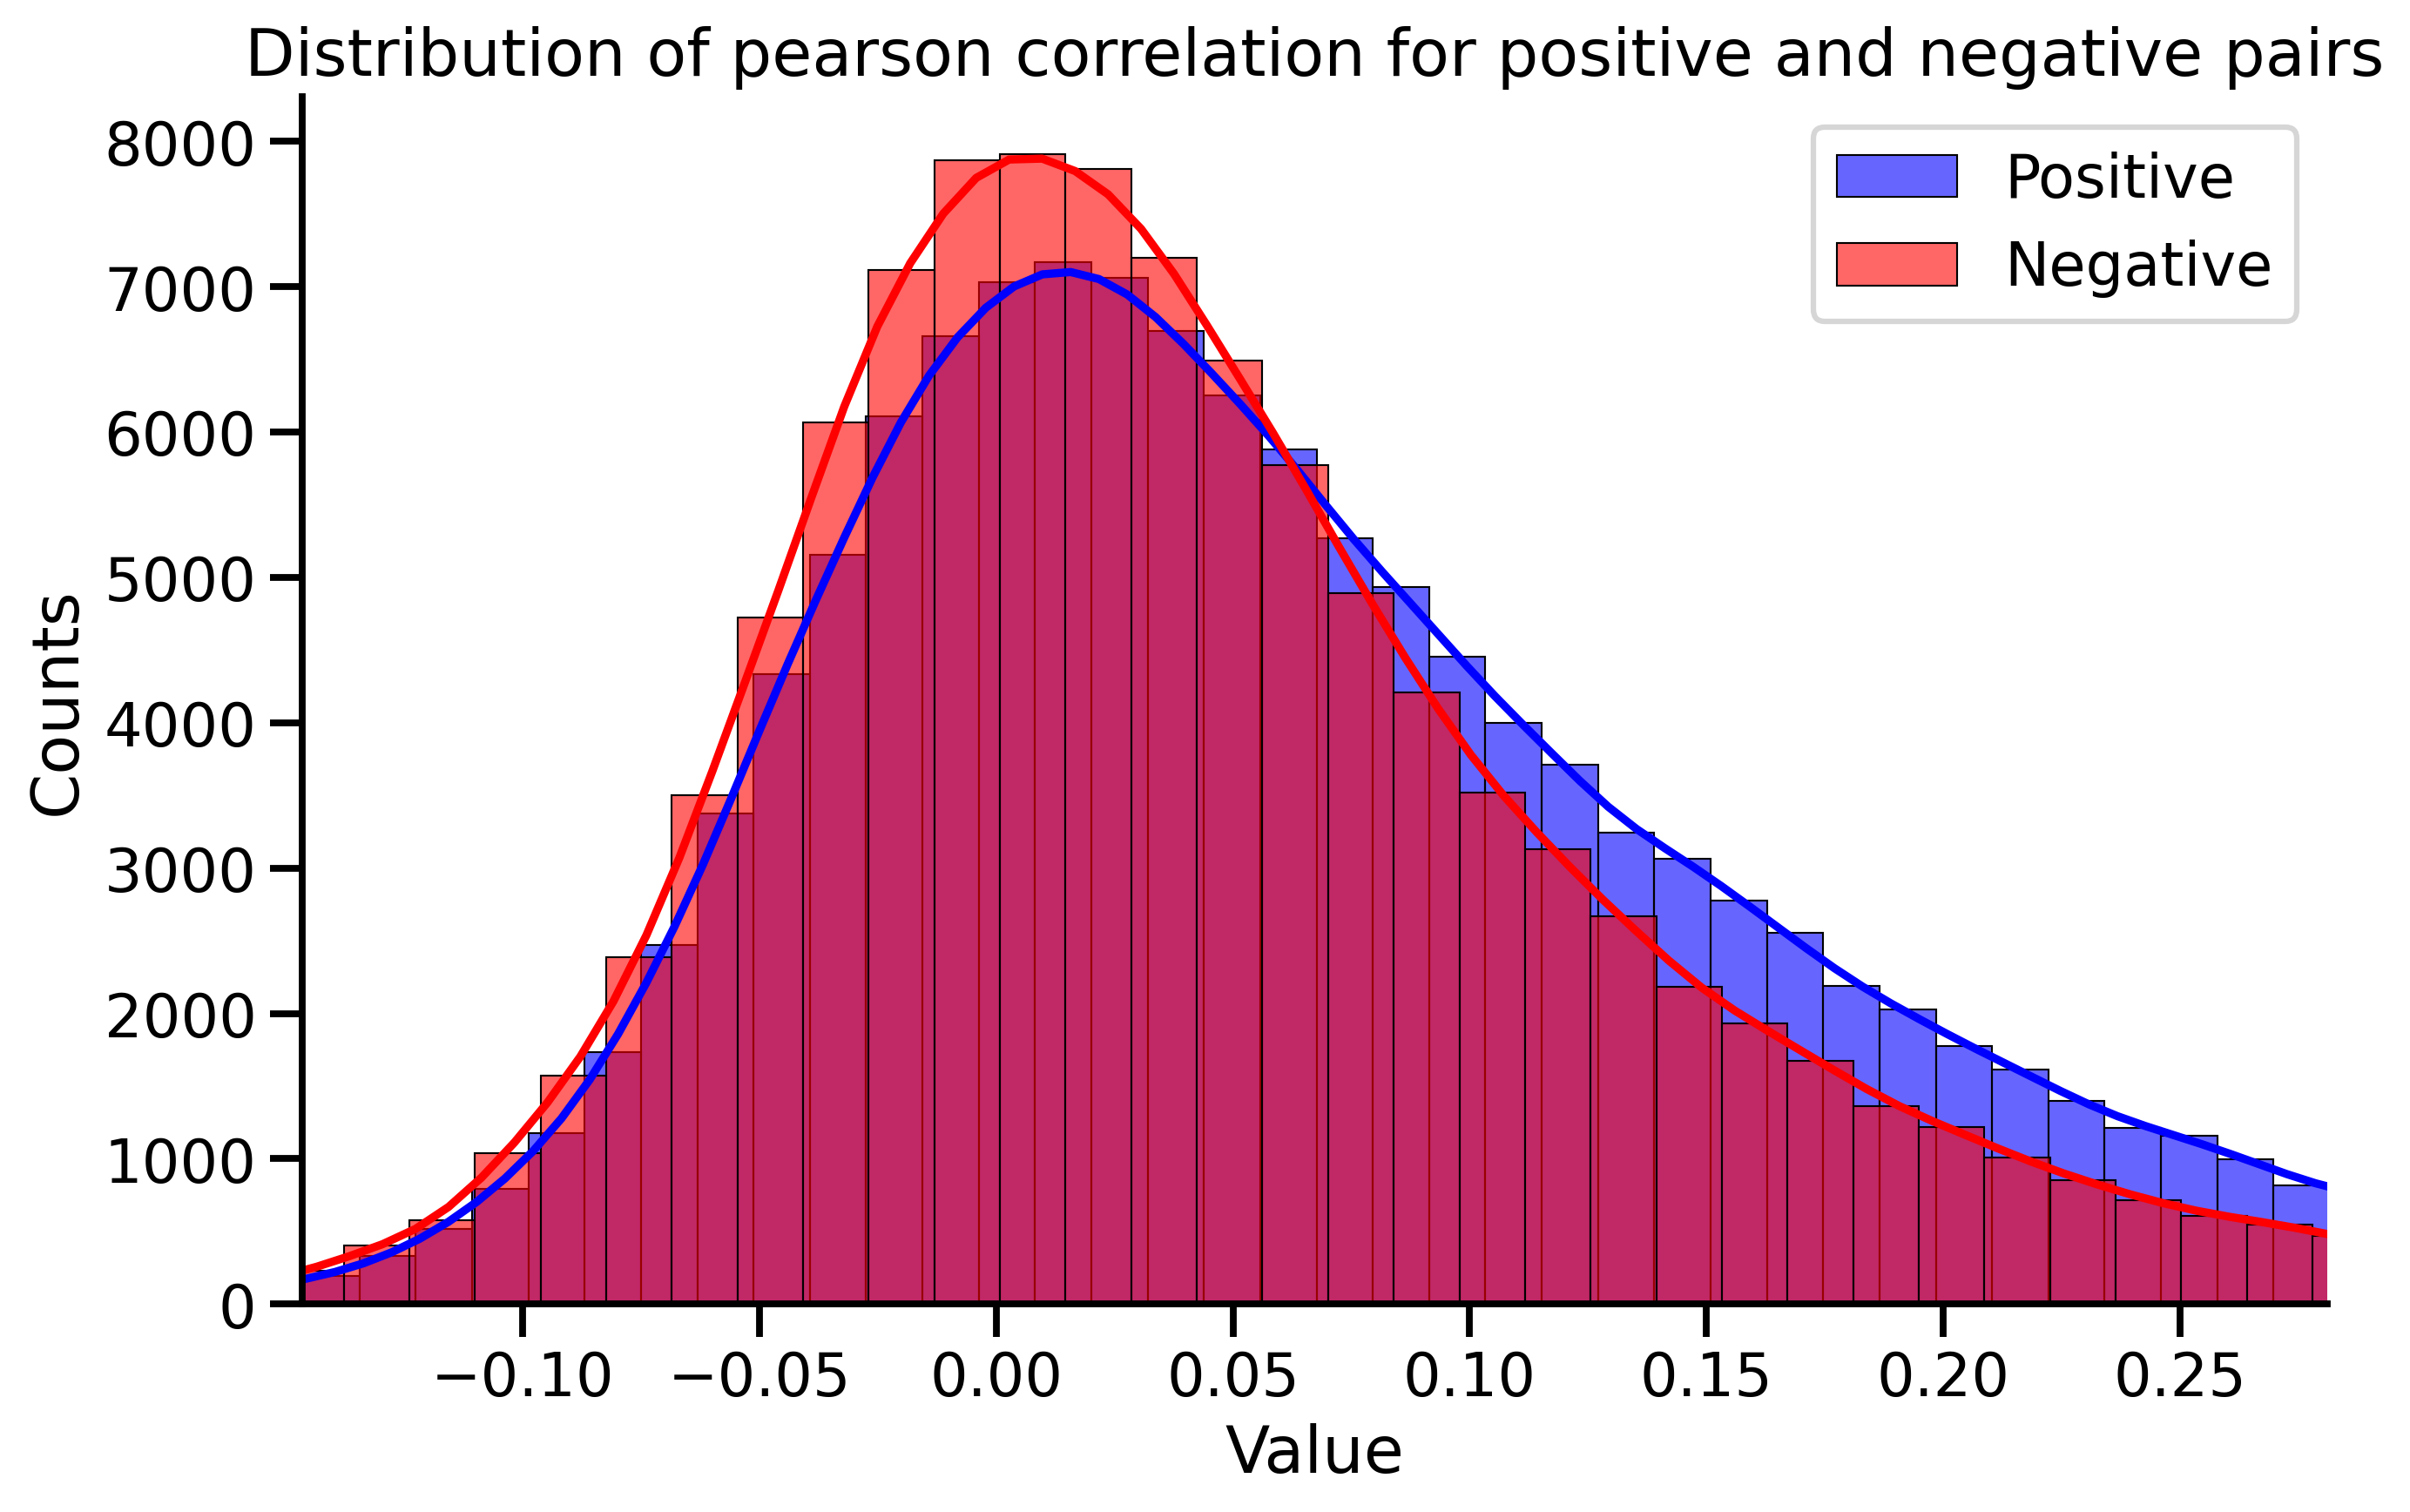

In [20]:
metric = "pearson_correlation"

l_positive = correlations_mamba_positive[metric]
l_negative = correlations_mamba_negative[metric]

plt.figure(figsize=(10, 6), dpi = 300)


sns.histplot(l_positive, bins=100, kde=True, color='blue', label='Positive', alpha=0.6)

sns.histplot(l_negative, bins=100, kde=True, color='red', label='Negative', alpha=0.6)

x_mean = np.mean(l_positive)
x_std = np.std(l_positive)
x_min = x_mean - 2 * x_std
x_max = x_mean + 2 * x_std

plt.xlim(x_min, x_max)

# hide the top and right spines
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# labels and title
title = " ".join(metric.split("_"))
plt.title(f'Distribution of {title} for positive and negative pairs')
plt.xlabel('Value')
plt.ylabel('Counts')
plt.legend()

plt.show()

In [21]:
kl_divergence_mamba, js_divergence_mamba = calculate_divergence(correlations_mamba_positive[metric], correlations_mamba_negative[metric])
kl_divergence_g2v, js_divergence_g2v = calculate_divergence(correlations_g2v_positive[metric], correlations_g2v_negative[metric])
kl_divergence_scgpt, js_divergence_scgpt = calculate_divergence(correlations_scgpt_positive[metric], correlations_scgpt_negative[metric])
kl_divergence_scfoundation, js_divergence_scfoundation = calculate_divergence(correlations_scfoundation_positive[metric], correlations_scfoundation_negative[metric])

/mmfs1/project/zhiwei/cq5/PythonWorkSpace/GeneMamba/genemamba/utils/utils.py:481: RuntimeWarning: invalid value encountered in divide
  return np.sum(P * np.log(P / Q))


In [22]:
diff_df["kl_divergence"] = [kl_divergence_mamba, kl_divergence_g2v, kl_divergence_scgpt, kl_divergence_scfoundation]
diff_df["js_divergence"] = [js_divergence_mamba, js_divergence_g2v, js_divergence_scgpt, js_divergence_scfoundation]
diff_df

,model,diff_ratio_pearson_correlation,diff_ratio_cosine_similarity,kl_divergence,js_divergence
0,GeneMamba,0.198704,0.198653,0.020695,0.004967
1,g2v,0.188758,0.188700,0.021144,0.005288
2,scgpt,0.101881,0.101876,0.007531,0.001882
3,scFoundation,-0.005005,-0.005006,NaN,NaN


/tmp/ipykernel_1180785/1387783471.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(labels)
/tmp/ipykernel_1180785/1387783471.py:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(labels)


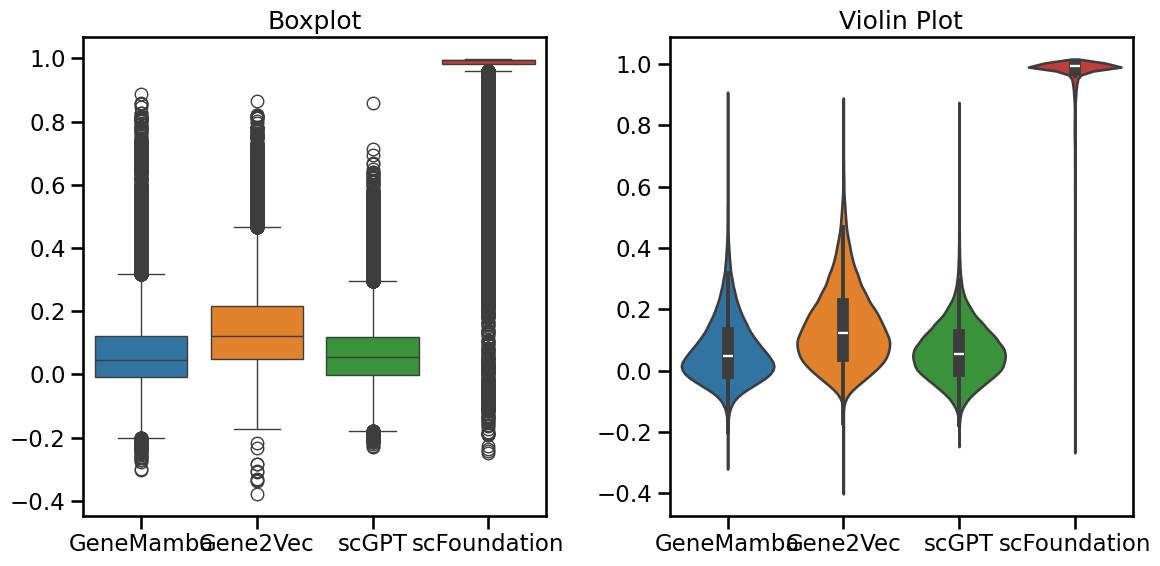

In [23]:
positive_mamba = np.array(correlations_mamba_positive[metric])
negative_mamba = np.array(correlations_mamba_negative[metric])
positive_g2v = np.array(correlations_g2v_positive[metric])
negative_g2v = np.array(correlations_g2v_negative[metric])
positive_scgpt = np.array(correlations_scgpt_positive[metric])
negative_scgpt = np.array(correlations_scgpt_negative[metric])
positive_scfoundation = np.array(correlations_scfoundation_positive[metric])
negative_scfoundation = np.array(correlations_scfoundation_negative[metric])

data_positive = [positive_mamba, positive_g2v, positive_scgpt, positive_scfoundation]
data_negative = [negative_mamba, negative_g2v, negative_scgpt, negative_scfoundation]

# define labels for the groups
labels = ['GeneMamba', 'Gene2Vec', 'scGPT', 'scFoundation']

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

sns.boxplot(data=data_positive, ax=axes[0])
axes[0].set_title('Boxplot')
axes[0].set_xticklabels(labels)


sns.violinplot(data=data_positive, ax=axes[1])
axes[1].set_title('Violin Plot')
axes[1].set_xticklabels(labels)

# Show the plot
plt.tight_layout()
plt.show()

In [24]:
correlations_random = {
    "pearson_correlation": np.random.rand(len(correlations_mamba["pearson_correlation"])).tolist(),
    "cosine_similarity": np.random.rand(len(correlations_mamba["cosine_similarity"])).tolist(),
}

In [31]:
model_name = "GeneMamba"

metric = "cosine_similarity"

mamba_array = np.array(correlations_mamba[metric])
g2v_array = np.array(correlations_g2v[metric])
random_array = np.array(correlations_random[metric])

if metric == "cosine_similarity":
    mamba_array = (mamba_array + 1) / 2
    g2v_array = (g2v_array + 1) / 2
    random_array = (random_array + 1) / 2


# normalize the arrays
# add a small constant to avoid log(0)
epsilon = 1e-6
mamba_array_norm = mamba_array + epsilon
g2v_array_norm = g2v_array + epsilon
random_array_norm = random_array + epsilon

mamba_array_norm = mamba_array_norm / np.sum(mamba_array_norm)
g2v_array_norm = g2v_array_norm / np.sum(g2v_array_norm)
random_array_norm = random_array_norm / np.sum(random_array_norm)


dist_g2v_mamba = np.linalg.norm(mamba_array - g2v_array)
dist_random_mamba = np.linalg.norm(mamba_array - random_array)
dist_g2v_random = np.linalg.norm(g2v_array - random_array)

def normlizeto1(x):
    return x / np.sum(x)


dist_g2v_mamba, dist_random_mamba, dist_g2v_random = normlizeto1(np.array([dist_g2v_mamba, dist_random_mamba, dist_g2v_random]))

print(f"Distance between G2V and {model_name}: {dist_g2v_mamba}, between Random and {model_name}: {dist_random_mamba}, between G2V and Random: {dist_g2v_random}")

kl_divergence_g2v_mamba = kl_divergence(mamba_array_norm, g2v_array_norm)
kl_divergence_random_mamba = kl_divergence(mamba_array_norm, random_array_norm)
kl_divergence_g2v_random = kl_divergence(g2v_array_norm, random_array_norm)

kl_divergence_g2v_mamba, kl_divergence_random_mamba, kl_divergence_g2v_random = normlizeto1(np.array([kl_divergence_g2v_mamba, kl_divergence_random_mamba, kl_divergence_g2v_random]))

print(f"KL Divergence between G2V and {model_name}: {kl_divergence_g2v_mamba}, between Random and {model_name}: {kl_divergence_random_mamba}, between G2V and Random: {kl_divergence_g2v_random}")

js_g2v_mamba = jensen_shannon_divergence(mamba_array_norm, g2v_array_norm)
js_random_mamba = jensen_shannon_divergence(mamba_array_norm, random_array_norm)
js_g2v_random = jensen_shannon_divergence(g2v_array_norm, random_array_norm)

js_g2v_mamba, js_random_mamba, js_g2v_random = normlizeto1(np.array([js_g2v_mamba, js_random_mamba, js_g2v_random]))

print(f"JS Divergence between G2V and {model_name}: {js_g2v_mamba}, between Random and {model_name}: {js_random_mamba}, between G2V and Random: {js_g2v_random}")

Distance between G2V and GeneMamba: 0.1368932600515865, between Random and GeneMamba: 0.4536670067531674, between G2V and Random: 0.409439733195246
KL Divergence between G2V and GeneMamba: 0.1459109674511734, between Random and GeneMamba: 0.41527871334752753, between G2V and Random: 0.4388103192012991
JS Divergence between G2V and GeneMamba: 0.14789203948739968, between Random and GeneMamba: 0.41417031715426217, between G2V and Random: 0.4379376433583381


In [32]:
import pandas as pd

data = {
    "Metrics": ["Euclidean Dist", "KL Divergence", "JS Divergence"],
    f"G2V and {model_name}": [dist_g2v_mamba, kl_divergence_g2v_mamba, js_g2v_mamba],
    f"Random and {model_name}": [dist_random_mamba, kl_divergence_random_mamba, js_random_mamba],
    "G2V and Random": [dist_g2v_random, kl_divergence_g2v_random, js_g2v_random],
}

df = pd.DataFrame(data)
df

,Metrics,G2V and GeneMamba,Random and GeneMamba,G2V and Random
0,Euclidean Dist,0.136893,0.453667,0.409440
1,KL Divergence,0.145911,0.415279,0.438810
2,JS Divergence,0.147892,0.414170,0.437938


In [33]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

cmap = LinearSegmentedColormap.from_list("custom_cmap", ["white", "blue", "red"])

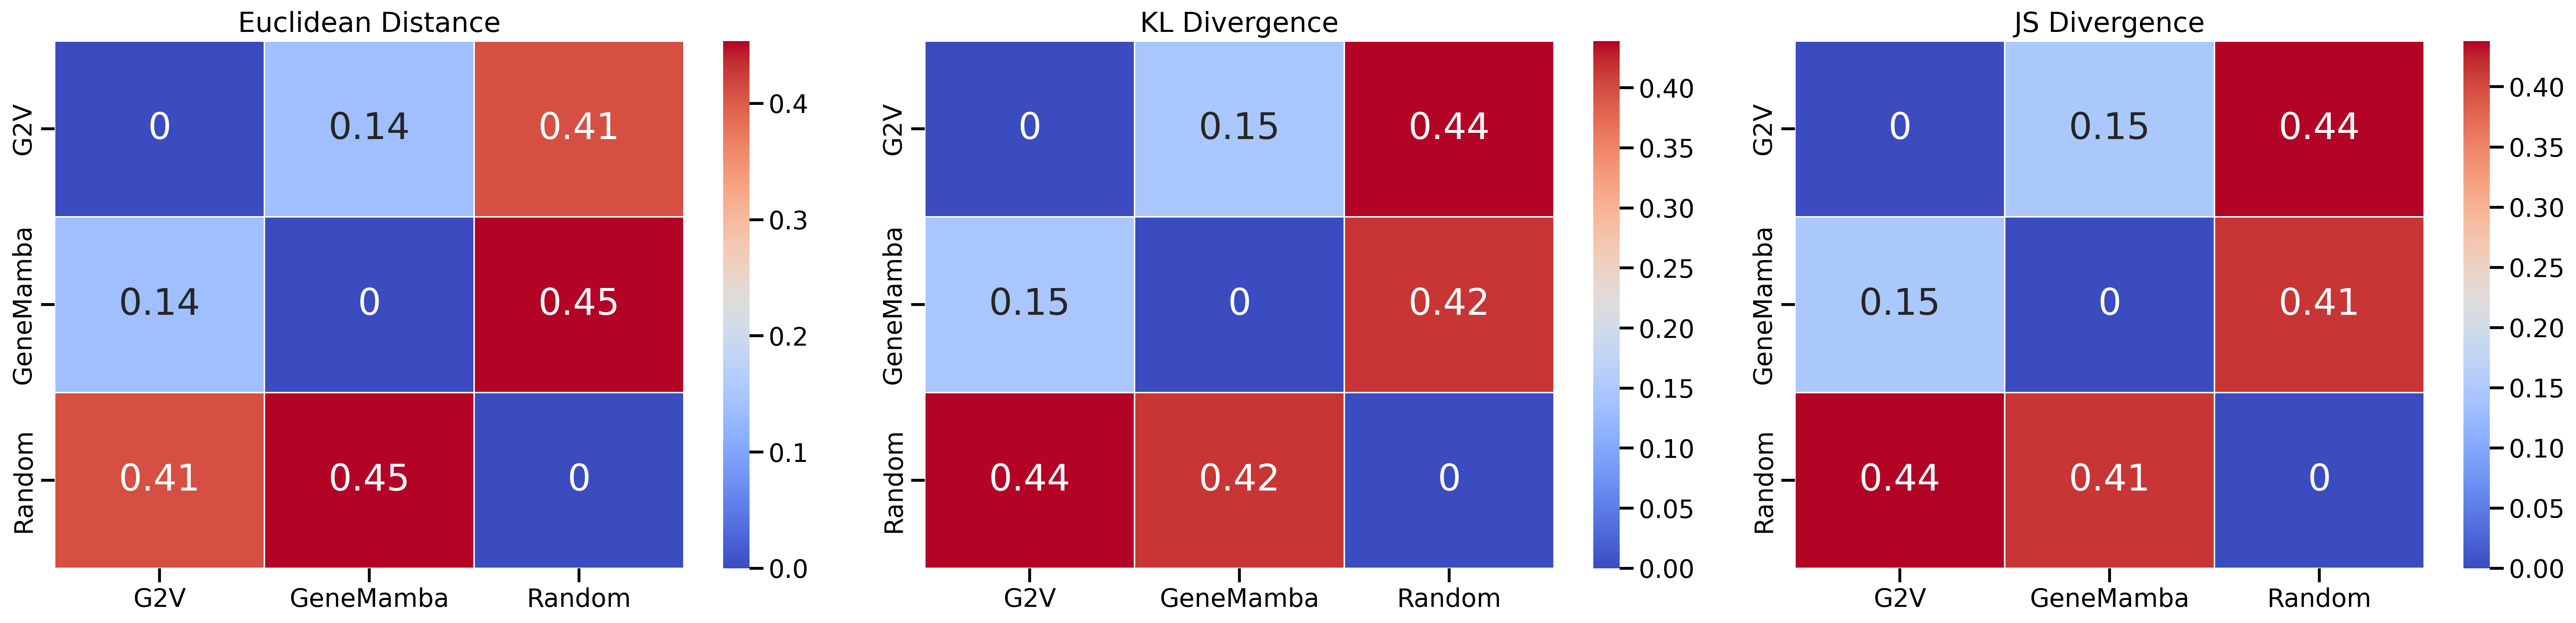

In [34]:
import seaborn as sns
import matplotlib.pyplot as plt

# prepare the data
dist_data = {
    "G2V": [0, dist_g2v_mamba, dist_g2v_random],
    model_name: [dist_g2v_mamba, 0, dist_random_mamba],
    "Random": [dist_g2v_random, dist_random_mamba, 0]
}

kl_divergence_data = {
    "G2V": [0, kl_divergence_g2v_mamba, kl_divergence_g2v_random],
    model_name: [kl_divergence_g2v_mamba, 0, kl_divergence_random_mamba],
    "Random": [kl_divergence_g2v_random, kl_divergence_random_mamba, 0],
}

js_divergence_data = {
    "G2V": [0, js_g2v_mamba, js_g2v_random],
    model_name: [js_g2v_mamba, 0, js_random_mamba],
    "Random": [js_g2v_random, js_random_mamba, 0],
}

dist_df = pd.DataFrame(dist_data, index=["G2V", model_name, "Random"])
kl_divergence_df = pd.DataFrame(kl_divergence_data, index=["G2V", model_name, "Random"])
js_divergence_df = pd.DataFrame(js_divergence_data, index=["G2V", model_name, "Random"])


fig, axes = plt.subplots(1, 3, figsize=(24, 6), dpi = 300)

sns.heatmap(dist_df, annot=True, cmap="coolwarm", linewidths=.5, ax=axes[0], annot_kws={"size": 24})
axes[0].set_title("Euclidean Distance")

# KL Divergence heatmap
sns.heatmap(kl_divergence_df, annot=True, cmap='coolwarm', linewidths=.5, ax=axes[1], annot_kws={"size": 24})
axes[1].set_title("KL Divergence")

# JS Divergence heatmap
sns.heatmap(js_divergence_df, annot=True, cmap='coolwarm', linewidths=.5, ax=axes[2], annot_kws={"size": 24})
axes[2].set_title("JS Divergence")

plt.tight_layout()
plt.show()